In [1]:
import torch
import torchvision
import torch.nn as nn
from torch.autograd import Variable
from torchvision import datasets, transforms
from model.wideVAE import *
from blackbox_pgd_model.wideresnet_update import *
from pgd_attack import *
import torch.optim as optim
import numpy as np
from util import *
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# parser = argparse.ArgumentParser(description='PyTorch CIFAR10 VAE Training')
# parser.add_argument('--batch-size', type=int, default=200, metavar='N',
#                     help='input batch size for training (default: 128)')
# parser.add_argument('--test-batch-size', type=int, default=200, metavar='N',
#                     help='input batch size for testing (default: 128)')
# parser.add_argument('--x-dim', type=int, default=784)
# parser.add_argument('--hidden-dim', type=int, default=400)
# parser.add_argument('--latent-dim', type=int, default=200)
# parser.add_argument('--epochs', type=int, default=30)
# args = parser.parse_args()
torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
])
batch_size = 200
test_batch_size = 200
beta = 0.5
trainset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, **kwargs)
testset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size, shuffle=False, **kwargs)

def train(vae_model, c_model, data_loader, vae_optimizer, c_optimizer, epoch_num):
    vae_model.train()
    c_model.train()
    v_loss_sum = 0
    c_loss_sum = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        #data = data.view(batch_size, x_dim)
        data, target = data.to(device), target.to(device)
        vae_optimizer.zero_grad()
        c_optimizer.zero_grad()
        x_hat, mean, log_v, x_ = vae_model(data)
        # x_cat = torch.cat((mean, log_v),1)
        logit = c_model(x_.detach().view(-1,160,8,8))
        #logit = c_model(x_cat)
        v_loss, c_loss = loss_function_mean(data, target, x_hat, mean, log_v, logit)
        #print(loss)
        v_loss_sum += v_loss
        c_loss_sum += c_loss
        # if epoch_num % 2 == 1:
        if epoch_num <= 30:
            v_loss.backward()
            vae_optimizer.step()
            c_loss.backward()
        else:
            c_loss.backward()
            c_optimizer.step()
            v_loss.backward()
    return v_loss_sum, c_loss_sum

def eval_train(vae_model, c_model):
    vae_model.eval()
    c_model.eval()
    err_num = 0
    with torch.no_grad():
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            x_hat, mean, log_v, x_ = vae_model(data)
            logit = c_model(x_.detach().view(-1,160,8,8))
            err_num += (logit.data.max(1)[1] != target.data).float().sum()
    print('train error num:{}'.format(err_num))
def eval_test(vae_model, c_model):
    vae_model.eval()
    c_model.eval()
    err_num = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            x_hat, mean, log_v, x_ = vae_model(data)
            logit = c_model(x_.detach().view(-1,160,8,8))
            err_num += (logit.data.max(1)[1] != target.data).float().sum()
    print('test error num:{}'.format(err_num))


Files already downloaded and verified
Files already downloaded and verified


In [2]:
def testtime_update(vae_model, c_model, x_adv, target, learning_rate=0.1, num = 30, mode = 'mean'):
    x_adv = x_adv.detach()
    x_hat_adv, mean, log_v, x_ = vae_model(x_adv)
    for _ in range(num):
        if (x_hat_adv != x_hat_adv).sum() > 0:
            print('nan Error')
            exit()
        if mode == 'mean':
            loss = nn.functional.binary_cross_entropy(x_hat_adv, x_adv, size_average=False, reduction='mean')
            # loss = vae_loss_mean(x_adv, x_hat_adv, mean, log_v)
        else:
            loss = nn.functional.binary_cross_entropy(x_hat_adv, x_adv, reduction='sum')
            # loss = vae_loss_sum(x_adv, x_hat_adv, mean, log_v)
        x_.retain_grad()
        loss.backward(retain_graph=True)
        with torch.no_grad():
            x_.data -= learning_rate * x_.grad.data
        x_.grad.data.zero_()
        x_hat_adv = vae_model.re_forward(x_)
    logit_adv = c_model(x_.view(-1,128,8,8))
        # print((logit_adv.data.max(1)[1] != target.data).float().sum())
    return logit_adv

In [3]:
def test(vae_model, c_model, source_model):
    err_num = 0
    err_adv = 0
    c_model.eval()
    vae_model.eval()
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data = Variable(data.data, requires_grad=True)
        _,_,_,x_ = vae_model(data)
        logit = c_model(x_.view(-1,128,8,8))
        # err_num += (logit.data.max(1)[1] != target.data).float().sum()

        # x_adv = pgd_cifar_blackbox(vae_model, c_model, source_model, data, target, 20, 0.03, 0.003)
        x_adv = pgd_cifar(vae_model, c_model, data, target, 20, 0.03, 0.003)
        _,_,_,x_ = vae_model(x_adv)
        logit_adv = c_model(x_.view(-1,128,8,8))
        logit_nat_new = testtime_update(vae_model, c_model,  data, target,learning_rate=0.01, num=100)
        logit_adv_new = testtime_update(vae_model, c_model,  x_adv, target,learning_rate=0.1, num=100)
        return logit, logit_adv,logit_nat_new, logit_adv_new, target
        # logit_adv = diff_update_cifar(vae_model,c_model, x_adv, target,learning_rate=0.05, num=500)
        # _,_,_,x_adv_ = vae_model(x_adv)
        # logit_adv = c_model(x_adv_.view(-1,160,8,8))
        # logit = c_model(x_.view(-1,160,8,8))
        adv_num = (logit_adv.data.max(1)[1] != target.data).float().sum()
        # exit()
        print(adv_num)
        err_adv += adv_num
        # x_cat_adv = torch.cat((m_adv, log_adv), 1)
        # logit_adv = c_model(x_cat_adv)
        # err_adv += (logit_adv.data.max(1)[1] != target.data).float().sum()
    print(len(test_loader.dataset))
    print(err_num)
    print(err_adv)

In [4]:
def adjust_learning_rate(optimizer, epoch, lr):
    """decrease the learning rate"""
    lr_ = lr
    if epoch >= 80:
        lr_ = lr * 0.1
    if epoch >= 90:
        lr_ = lr * 0.01
    if epoch >= 100:
        lr_ = lr * 0.001
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr_
    

In [5]:
source_model = WideResNet().to(device)
# source_model_path = './blackbox_pgd_model/model-wideres-epoch76.pt'
vae_model = wide_VAE(zDim=256).to(device)
c_model = classifier().to(device)
vae_model_path = './model-checkpoint/cifar-vae-model-98.pt'
c_model_path = './model-checkpoint/cifar-c-model-98.pt'
# source_model.load_state_dict(torch.load(source_model_path))
vae_model.load_state_dict(torch.load(vae_model_path))
c_model.load_state_dict(torch.load(c_model_path))

In [6]:

# lr = 0.001
# epochs = 90
# vae_model = wide_VAE(zDim=256).to(device)
# vae_optimizer = optim.Adam(vae_model.parameters(), lr=lr)
# c_model = classifier().to(device)
# c_optimizer = optim.Adam(c_model.parameters(), lr=lr*10)
# print(len(train_loader.dataset))
# for epoch in range(1, epochs+1):
#     adjust_learning_rate(c_optimizer, epoch, lr*10)
#     v_loss, c_loss = train(vae_model,c_model, train_loader, vae_optimizer, c_optimizer, epoch)
#     print('Epoch {}: VAE Average loss: {:.6f}'.format(epoch, v_loss/len(train_loader.dataset)))
#     print('Epoch {}: Classifier Average loss: {:.6f}'.format(epoch, c_loss/len(train_loader.dataset)))
# test(vae_model, c_model)

In [7]:
import matplotlib.pyplot as plt
def show_image(x, idx):
    x = x.view(test_batch_size,3, 32, 32)
    # x = x.detach().cpu().numpy()
    # x = x.transpose(0,2,3,1).astype("uint8")
    fig = plt.figure()
    plt.imshow(transforms.ToPILImage()(x[idx]))

In [6]:
logit, logit_adv,logit_nat_new, logit_adv_new, target = test(vae_model, c_model, source_model)

/home/hao/anaconda3/envs/test/lib/python3.7/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [9]:
# label = logit_calculate(logit_adv, logit_adv_new)
label = logit_calculate(logit, logit_nat_new)
label = label.to(device)
print((logit.data.max(1)[1]!=target).sum())
print((label!=target).sum())
print(label)
print(target)

tensor(28, device='cuda:0')
tensor(35, device='cuda:0')
tensor([3., 8., 8., 0., 4., 6., 1., 6., 3., 1., 0., 9., 5., 7., 9., 8., 5., 7.,
        8., 6., 7., 0., 4., 9., 5., 2., 4., 0., 9., 6., 4., 5., 4., 2., 9., 7.,
        4., 1., 9., 5., 4., 6., 5., 6., 0., 9., 3., 9., 7., 6., 9., 8., 5., 3.,
        8., 8., 5., 3., 5., 6., 7., 5., 6., 9., 6., 2., 1., 2., 7., 7., 4., 5.,
        8., 8., 9., 2., 9., 3., 3., 8., 8., 1., 1., 7., 2., 7., 2., 7., 8., 9.,
        0., 3., 8., 6., 4., 5., 6., 0., 0., 7., 4., 5., 6., 3., 1., 1., 3., 6.,
        8., 7., 3., 0., 2., 2., 1., 3., 0., 9., 7., 5., 8., 7., 1., 2., 8., 7.,
        8., 3., 5., 3., 4., 1., 8., 9., 5., 2., 9., 7., 2., 8., 6., 5., 6., 3.,
        8., 7., 6., 2., 5., 2., 8., 9., 6., 0., 0., 5., 2., 9., 5., 4., 2., 1.,
        5., 6., 0., 2., 8., 6., 5., 0., 9., 6., 9., 8., 9., 9., 3., 7., 5., 0.,
        0., 5., 2., 2., 0., 8., 6., 2., 2., 0., 5., 8., 0., 1., 7., 5., 8., 8.,
        7., 8.], device='cuda:0')
tensor([3, 8, 8, 0, 6, 6, 1, 6

In [16]:
logit_diff = logit_nat_new - logit
temp=[]
label = logit.data.max(1)[1]
for i in range(200):
    # temp.append(round(logit_diff[i][logit.data.max(1)[1][i].item()].item() / logit[i][logit.data.max(1)[1][i].item()].item() * 100, 2))
    temp.append(round(logit_diff[i][label[i].item()].item() / logit[i][label[i].item()].item() * 100, 2))
print(temp)

[-4.27, -0.05, 5.44, -0.9, 4.33, -0.08, 1.1, -0.88, -0.22, 0.22, -2.77, 1.57, -0.68, -0.6, -0.14, 12.37, -0.53, 0.83, -1.83, -3.88, -2.3, -1.12, -3.69, 1.77, -2.63, -3.94, -4.21, -0.97, -1.1, -0.45, -15.13, -3.57, -0.35, 9.06, 2.16, 13.74, -0.91, -3.39, 0.47, 0.86, 1.6, -0.22, 3.35, -1.58, 0.97, 0.83, 1.65, 24.35, 0.57, 0.33, 0.06, -1.38, 10.67, -0.71, 2.19, 0.85, 4.74, -5.61, 0.52, -2.57, -0.39, 3.46, -0.69, 2.92, -2.46, 6.08, 1.58, 2.19, 10.43, -1.57, -15.63, -10.95, 4.56, 0.41, 39.85, 0.07, -4.38, 0.19, -3.48, 3.62, -2.22, -1.42, -0.0, -1.16, 0.93, -0.78, 2.76, -6.01, 3.42, 0.95, 0.69, -1.41, 0.53, -2.19, -7.31, 1.32, 1.47, -0.96, 1.47, 1.93, 4.19, 1.79, 3.75, 1.23, -0.45, 1.23, 1.55, -1.18, 1.79, 0.56, -11.63, 2.44, 5.23, -3.59, 1.82, -0.07, -0.35, -63.65, 11.33, 2.46, -2.32, 0.83, 2.41, 0.4, -4.93, -14.76, -0.21, 9.43, 0.31, -18.81, -0.41, 2.06, 1.87, -1.62, 75.18, 0.19, 2.73, -2.26, 1.32, -2.36, 2.58, 1.9, 1.1, 5.51, -5.72, -14.94, -5.24, 7.77, 4.07, -2.08, 7.59, 0.22, 1.55, -2.0

In [12]:
idx = 1
print(target[idx])
print(logit[idx])

tensor(8, device='cuda:0')
tensor([ -4.2184,  -5.2206, -13.7704, -14.5198, -14.9531, -11.3493, -16.8815,
        -15.2519,  12.5187,  -5.5974], device='cuda:0',
       grad_fn=<SelectBackward0>)


In [13]:
print(logit_nat_new[idx])

tensor([ -3.7874,  -6.1135, -13.2801, -14.6573, -15.5637, -11.2632, -16.9037,
        -14.7154,  12.5125,  -5.1013], device='cuda:0',
       grad_fn=<SelectBackward0>)


In [14]:
print(logit_adv[idx])
print(logit_adv_new[idx])


tensor([ 14.6454,  -7.6334, -12.7084, -18.8223, -21.1263, -16.8193, -15.8491,
         -9.8745, -10.7161, -12.5980], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([ 13.9744,  -6.5202, -13.1916, -20.0648, -21.5021, -17.3619, -15.2067,
         -9.2283, -10.3347, -11.3202], device='cuda:0',
       grad_fn=<SelectBackward0>)


In [35]:
logit_nat_new.max(1)

torch.return_types.max(
values=tensor([ 6.6484, 16.3670,  9.2583,  8.9384, 13.5887,  5.3610, 17.4120,  7.7241,
        13.8551, 14.1609, 10.9950, 24.4618,  5.8903, 23.1151, 17.9990, 12.0400,
        15.5626, 11.4088, 10.3357, 16.8526,  7.4911, 15.9793,  3.7088, 19.3503,
        10.6145,  4.0728, 11.5412, 13.6083, 13.7420, 23.8032,  5.8181, 12.9534,
        11.9304,  4.4098, 20.6128,  2.0085, 13.2373,  7.8153, 17.3060, 13.5526,
        12.9329, 16.3520, 18.7226, 16.1867,  9.7710, 14.0004, 12.4873,  2.1354,
        16.0314, 19.5331, 13.3210, 10.7148,  4.3840, 11.4763, 23.9780, 19.3649,
         7.5021,  4.6164,  6.7759,  5.3750, 21.0769,  6.6727,  7.0914,  8.0792,
        19.5412, 11.8959, 10.7430, 14.4537,  8.7876,  3.4617,  1.5767,  6.6984,
        18.2462, 18.9652,  3.9671, 18.1006,  5.8063,  7.6863,  8.9836, 19.5640,
        19.4270,  9.1915, 25.8421,  5.8348, 12.6548,  8.3297,  0.8794,  4.8260,
        19.5725, 23.2648, 17.0319,  9.9516, 15.3509, 16.9033, 10.8432,  0.9966,
        1

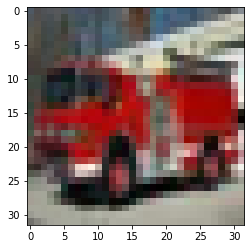

In [17]:
idex = 23
show_image(x, idx=idex)

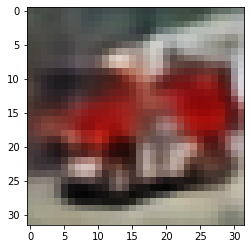

In [18]:
show_image(x_hat, idx=idex)

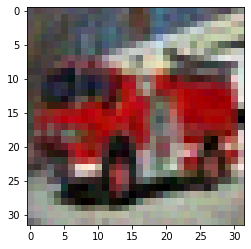

In [19]:
show_image(x_adv, idx=idex)

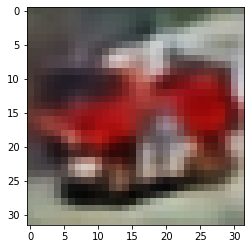

In [20]:
show_image(x_hat_adv, idx=idex)

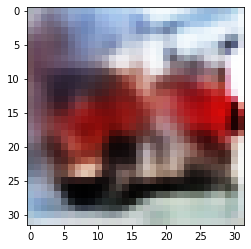

In [21]:
show_image(x_hat_new, idx=idex)

In [3]:
vae_model = wide_VAE(zDim=256).to(device)
vae_optimizer = optim.Adam(vae_model.parameters(), lr=0.001)
c_model = classifier().to(device)
c_optimizer = optim.Adam(c_model.parameters(), lr=0.01)
print('testing mode')
model_dir = './model-checkpoint'
test_num = 90
vae_model_path = '{}/cifar-vae-model-{}.pt'.format(model_dir, test_num)
c_model_path = '{}/cifar-c-model-{}.pt'.format(model_dir, test_num)
vae_model.load_state_dict(torch.load(vae_model_path))
c_model.load_state_dict(torch.load(c_model_path))
c_model.eval()
vae_model.eval()
for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    data = Variable(data.data, requires_grad=True)
    # logit = model_pred(data, vae_model, c_model)
    # err_num += (logit.data.max(1)[1] != target.data).float().sum()
    # x_adv = pgd(vae_model, c_model, data, target, 20, 0.03, 0.003)
    # x_ = testtime_update(vae_model, x_adv ,learning_rate=0.15, num=100)
    _,_,_,x_ = vae_model(data)
    logit = c_model(x_.view(-1,160,8,8))
    break

testing mode
